In [2]:
!pip install transformers datasets sentence-transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import random

# Rest of the code remains the same...



In [13]:
# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the open-source LLM and tokenizer, and move the model to the correct device
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token  # Use the end-of-sequence token as the padding token

# Load a similarity model for evaluation, move it to device
similarity_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

# Updated generate_task and generate_response to use device for inputs and outputs
def generate_task(topic, difficulty):
    prompt = f"Generate a {difficulty} level question in {topic}."
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=50)
    question = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return {'prompt': question, 'expected_answer': f"Expected answer for a {difficulty} level question in {topic}."}

def generate_response(task_prompt):
    inputs = tokenizer(task_prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=50)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Fine-tune the model on generated question-answer pairs
def fine_tune_model(questions, answers):
    # Prepare dataset for training
    data = {'input_text': [q for q in questions], 'label_text': [a for a in answers]}
    dataset = Dataset.from_dict(data)

    def tokenize_function(examples):
        # Tokenize the inputs and set the labels
        inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True)
        labels = tokenizer(examples["label_text"], padding="max_length", truncation=True)
        inputs["labels"] = labels["input_ids"]
        return inputs

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Define training arguments with no evaluation
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="no",  # Disable evaluation
        num_train_epochs=1,
        per_device_train_batch_size=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets,  # Only training dataset
    )

    # Train the model
    trainer.train()



# Ensure all device settings are correct in the adaptive learning loop

# Main adaptive learning cycle
def adaptive_learning_cycle(topics, difficulty_levels, iterations=5):
    log = []  # Log for tasks and responses
    questions, answers = [], []  # For fine-tuning data

    for _ in range(iterations):
        # Randomly select topic and difficulty
        topic = random.choice(topics)
        difficulty = random.choice(difficulty_levels)

        # Step 1: Generate task
        task = generate_task(topic, difficulty)

        # Step 2: Generate response
        response = generate_response(task['prompt'])

        # Step 3: Evaluate response
        score = evaluate_response(response, task['expected_answer'])

        # Adaptive difficulty adjustment based on score
        if score > 0.85 and difficulty != 'Hard':
            difficulty = 'Medium' if difficulty == 'Easy' else 'Hard'
        elif score < 0.6 and difficulty != 'Easy':
            difficulty = 'Medium' if difficulty == 'Hard' else 'Easy'

        # Log task and response
        log.append({
            'topic': topic,
            'difficulty': difficulty,
            'task_prompt': task['prompt'],
            'expected_answer': task['expected_answer'],
            'response': response,
            'score': score
        })

        # Prepare data for fine-tuning
        questions.append(task['prompt'])
        answers.append(task['expected_answer'])

    # Fine-tune model on the generated data
    fine_tune_model(questions, answers)

    # Return the log of activities for review
    return pd.DataFrame(log)

# Execute the adaptive learning cycle
topics = ['Math', 'Science', 'History']
difficulty_levels = ['Easy', 'Medium', 'Hard']
learning_log_df = adaptive_learning_cycle(topics, difficulty_levels, iterations=10)

# Display log of activities
print(learning_log_df)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_tok

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss


     topic difficulty                                        task_prompt  \
0  History       Easy  Generate a Easy level question in History.\n\n...   
1     Math     Medium  Generate a Hard level question in Math.\n\nThe...   
2  Science       Easy  Generate a Easy level question in Science.\n\n...   
3     Math       Easy  Generate a Easy level question in Math.\n\nThe...   
4  History       Easy  Generate a Easy level question in History.\n\n...   
5  History     Medium  Generate a Hard level question in History.\n\n...   
6  History       Easy  Generate a Easy level question in History.\n\n...   
7  History       Easy  Generate a Medium level question in History.\n...   
8     Math       Easy  Generate a Easy level question in Math.\n\nThe...   
9     Math       Easy  Generate a Easy level question in Math.\n\nThe...   

                                     expected_answer  \
0  Expected answer for a Easy level question in H...   
1  Expected answer for a Hard level question in M..

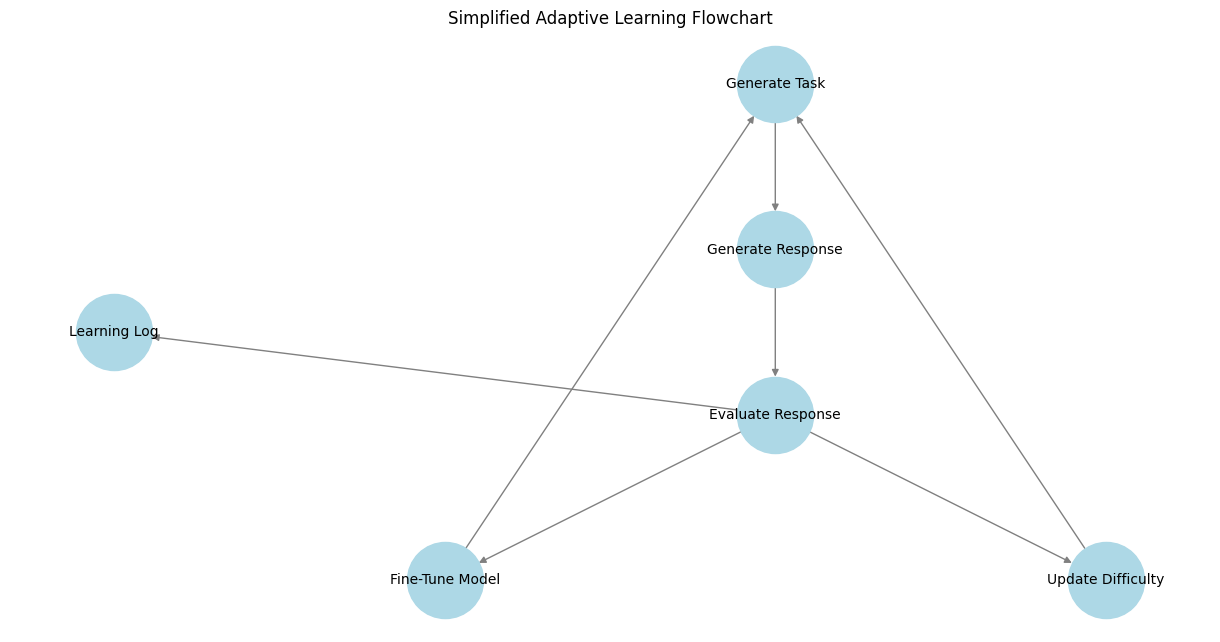

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the graph for a simplified adaptive learning flowchart
G = nx.DiGraph()

# Adding nodes in a simplified structure
G.add_node("Generate Task", pos=(0, 3))
G.add_node("Generate Response", pos=(0, 2))
G.add_node("Evaluate Response", pos=(0, 1))
G.add_node("Update Difficulty", pos=(1, 0))
G.add_node("Fine-Tune Model", pos=(-1, 0))
G.add_node("Learning Log", pos=(-2, 1.5))

# Adding edges to clarify process flow
G.add_edges_from([
    ("Generate Task", "Generate Response"),
    ("Generate Response", "Evaluate Response"),
    ("Evaluate Response", "Update Difficulty"),  # Branch to adjust difficulty
    ("Evaluate Response", "Fine-Tune Model"),    # Branch to fine-tune model
    ("Fine-Tune Model", "Generate Task"),        # Fine-tuned model returns to task generation
    ("Update Difficulty", "Generate Task"),      # Difficulty adjustment loop back to task generation
    ("Evaluate Response", "Learning Log"),       # Log the evaluation results
])

# Set positions and draw
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(12, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10, node_color='lightblue', edge_color='gray', arrows=True)
plt.title("Simplified Adaptive Learning Flowchart")
plt.show()
